# This notebook shows training of conditional probability networks.

set work directory to the "Single_Particle_Tracking" folder

download and upzip [data and intermediate results](https://drive.google.com/open?id=1AO6du609gYup2mcyKIWEqU5dH5p8Fa4K) to work directory

In [7]:
from __future__ import print_function

import keras 
from keras.datasets import mnist
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Bidirectional, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Reshape, Activation
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization


%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import random 
import numpy as np

from skimage import measure
from skimage.measure import label 
import scipy as sp
import scipy.ndimage.morphology

In [3]:
# load blury images (obs.tif) and ground truth (labels.tif)

folder = './data_and_pre_calculated_results/'

from skimage import io
obs = io.imread(folder+'obs.tif').astype('float32')
labels = io.imread(folder+'label.tif').astype('float32')
img_size = obs.shape[-1]

print(obs.shape)
print(labels.shape)

(10000, 60, 60)
(10000, 60, 60)


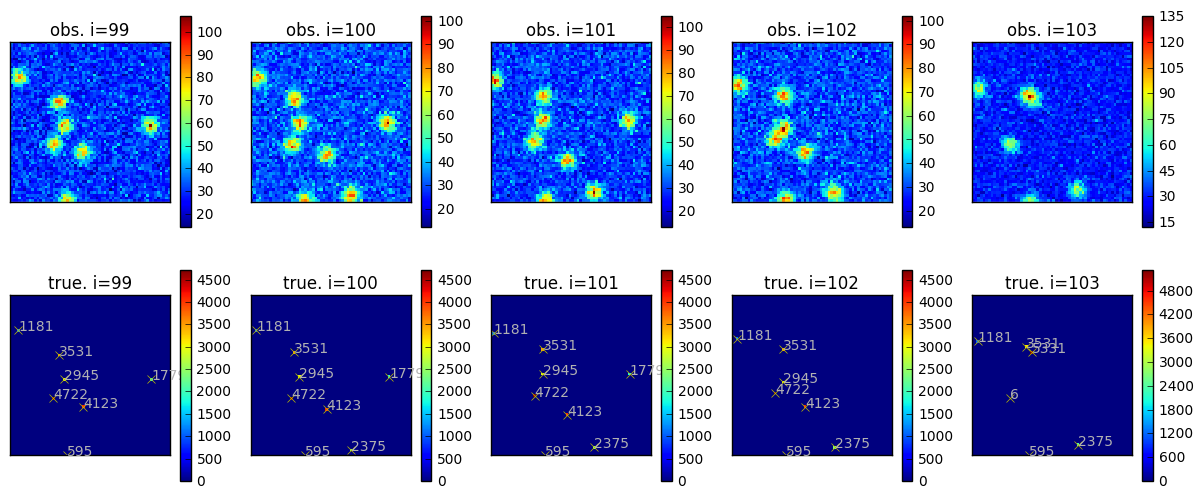

In [4]:
# plot raw data  
import random 
n = 5
i_base = random.randint(0,200) 
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(obs[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(labels[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)

In [5]:
# Normalize data

T_train = 9000  
T_all = 10000 

x_train = obs[0:T_train,:,:]
x_train_before_normalization = x_train.copy() 
print(x_train.shape)
y_train = labels[0:T_train,:,:]
print(y_train.shape)

x_test = obs[T_train:T_all,:,:]
x_test_before_normalization = x_test.copy() 
print(x_test.shape)
y_test = labels[T_train:T_all,:,:]
print(y_test.shape)


x_train = x_train.astype('float32')    
x_test = x_test.astype('float32')    
 
#normalization 
for idx in range(x_train.shape[0]):
    x_train[idx,:,:] = x_train[idx,:,:]/x_train[idx,:,:].max()
 
    
for idx in range(x_test.shape[0]):
    x_test[idx,:,:] = x_test[idx,:,:]/x_test[idx,:,:].max()

(9000, 60, 60)
(9000, 60, 60)
(1000, 60, 60)
(1000, 60, 60)


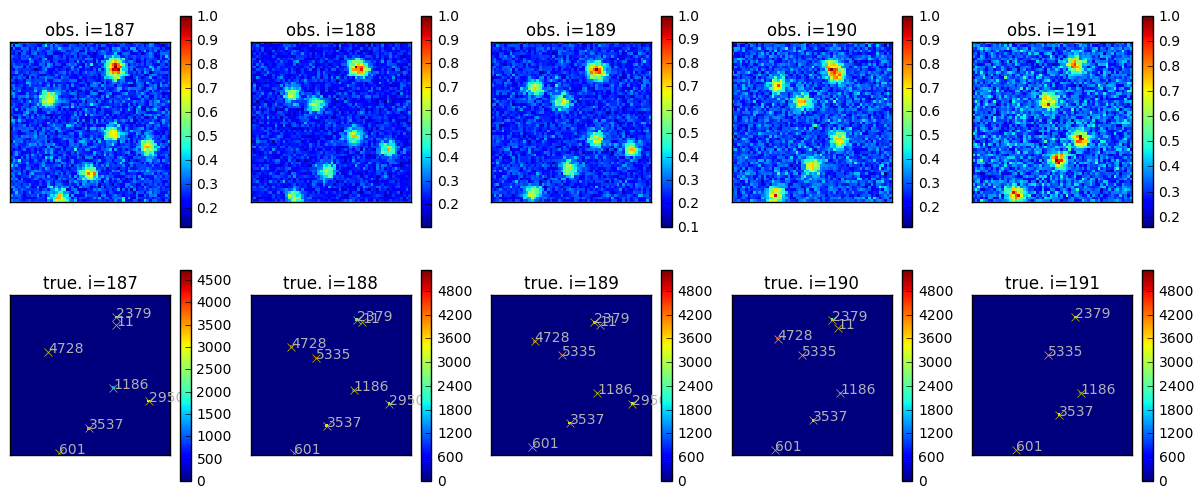

In [5]:
# plot data after normalization
import random 
n = 5
i_base = random.randint(0,200)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(y_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)

# prepare NN input and output

In [13]:
# compute input and output for conditional probability neural networks. 

Ntrain = len(range(2,x_train.shape[0])) - 2 # remove t=0 and 1

nfeatures = 8 #

NN_inputs = np.zeros([Ntrain, nfeatures, img_size, img_size, 1])  
NN_outputs = np.zeros([Ntrain, img_size, img_size, 1])  


for t in range(2,x_train.shape[0]-2):

    if t%1000==0:
        print(t)
        
    # observations: t-2, t-1, t, t+1, t+2 
    images = x_train[t-2:t+3,:,:]
    
    # particles mask in t-1 (history)
    t_minus_1_mask = np.zeros([img_size, img_size])
    t_minus_1_mask[np.where(y_train[t-1,:,:]!=0)] = 1    
    t_minus_1_values = np.unique(y_train[t-1,:,:])
    t_minus_1_particles = t_minus_1_values[t_minus_1_values!=0] # particles at t-1
    nparticles = len(t_minus_1_particles) # number of particles at t-1
    
    # for sampling at t, from the pool of particles at t-1, random draw a subset of particles as "sampled partilces", 
    # the rest are particles to sample. 
    sampled_binary_mask = np.random.binomial(1, .5, nparticles)                                 
    sampled_particles = t_minus_1_particles[np.where(sampled_binary_mask==1)]
    to_sample_particles = t_minus_1_particles[np.where(sampled_binary_mask==0)]
    sampled_number = len(sampled_particles)
    
    # sampled at t
    t_mask_sampled = np.zeros([img_size, img_size]) 
    for i_sampled in range(len(sampled_particles)):
        var = t_mask_sampled[np.where(y_train[t,:,:] ==  sampled_particles[i_sampled])] 
        if var!=0:
            raise('sampled two')
        t_mask_sampled[np.where(y_train[t,:,:] ==  sampled_particles[i_sampled])] = 1
        
    # sample one new particle id for sampling at t
    if len(to_sample_particles) != 0:
        id_to_sampling = np.random.randint(len(to_sample_particles))
        particle_id_to_sampling =  to_sample_particles[id_to_sampling]
         
        
        t_minus_1_mask_sampling = np.zeros([img_size, img_size])
        t_minus_1_mask_sampling[np.where(y_train[t-1,:,:] == particle_id_to_sampling)] = 1
             
        # target (at t)
        t_mask_sampling = np.zeros([img_size, img_size])
        t_mask_sampling[np.where(y_train[t,:,:] == particle_id_to_sampling)] = 1 
                        
    else:
         
        t_minus_1_mask_sampling = np.zeros([img_size, img_size])
        t_mask_sampling = np.zeros([img_size, img_size])
            

        
    # expand dimension
    t_minus_1_mask = np.expand_dims(t_minus_1_mask,axis=0)
    t_mask_sampled = np.expand_dims(t_mask_sampled,axis=0)
    t_minus_1_mask_sampling = np.expand_dims(t_minus_1_mask_sampling,axis=0)
    t_mask_sampling  = np.expand_dims(t_mask_sampling,axis=0)
    
    inputs = np.concatenate((images, t_minus_1_mask, t_mask_sampled, t_minus_1_mask_sampling), axis=0)
    
    NN_inputs[t-2,:,:,:,0] = inputs   #remove t=0 and 1 in NN_inputs or NN_output
    NN_outputs[t-2,:,:,0] = t_mask_sampling 
   

1000
2000
3000
4000
5000
6000
7000
8000


In [7]:
print(NN_outputs.shape)
print(NN_inputs.shape)

(8996, 60, 60, 1)
(8996, 8, 60, 60, 1)


In [8]:
NN_outputs1 = np.expand_dims(NN_outputs, axis=1)  # extend a dimension for NN input
NN_outputs1.shape

(8996, 1, 60, 60, 1)

In [16]:
# save 
np.save(folder+'NN_inputs_sampling',NN_inputs)
np.save(folder+'NN_outputs1_sampling',NN_outputs1)

# plot NN input and output

In [9]:
def label_im(im, marker_info, marker_label, if_text=0):
    
    # plot markers on images
    
    im_uni_values = im[im!=0]

    sz = im.shape[0]
    
    myidx = np.where(im!=0)
    for u in range(len(im_uni_values)):
 
        values =  im[myidx[0][u],myidx[1][u]]
         
        if if_text:
            plt.text(myidx[1][u],myidx[0][u],(values), color='w')
        if u==0:
            plt.plot(myidx[1][u],myidx[0][u], marker_info, label=marker_label)
        else:
            plt.plot(myidx[1][u],myidx[0][u], marker_info)
        
    plt.legend()    
    plt.xlim(0,sz-1)
    plt.ylim(sz-1,0)

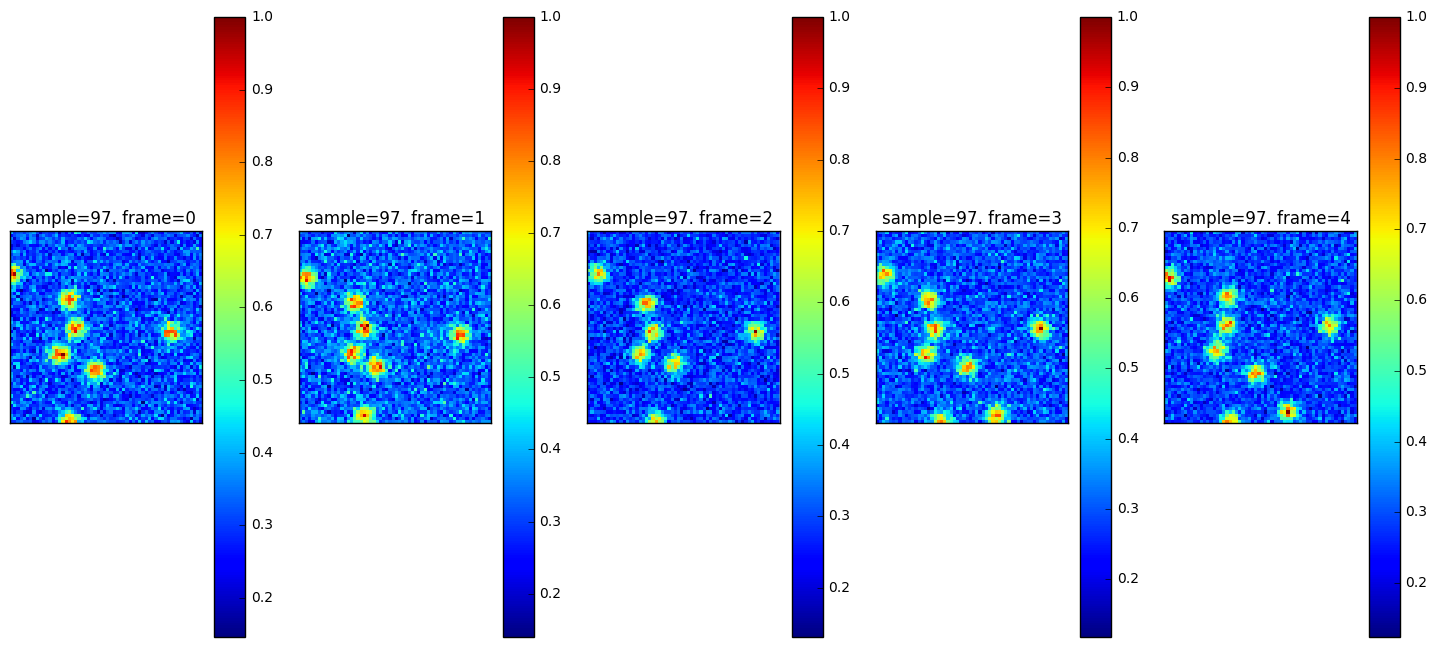

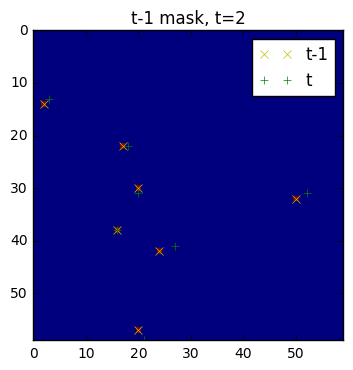

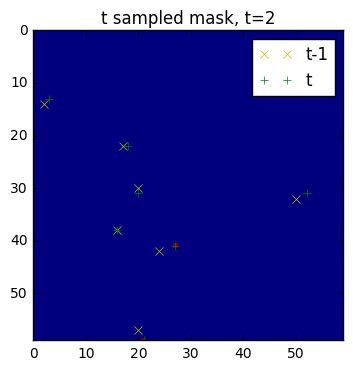

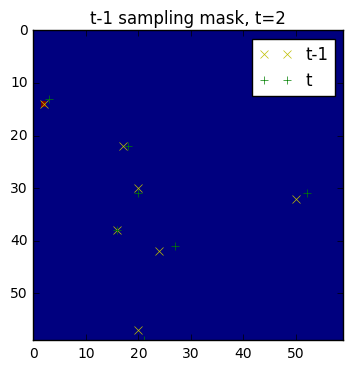

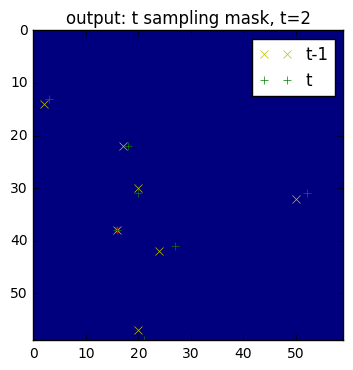

In [16]:
# visualize NN input and output (for debug) 
import random 
img_size = 60
n = 5
i_base = random.randint(0,100) #72
plt.figure(figsize=(18, 8))

       
true_t_minus_1 =  y_train[i_base+1,:,:]  
true_t =  y_train[i_base+2,:,:] 

        
for i in range(n):
 
    
    ax = plt.subplot(1, n, i+1)
    plt.imshow(NN_inputs[i_base,i,:,:,0].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('sample=%d. frame=%d'%(i_base, i))
    plt.colorbar()
    
    
plt.figure()
plt.imshow(NN_inputs[i_base,5,:,:,0].reshape(img_size, img_size),interpolation='none')
plt.title('t-1 mask, t=%d'%(2))
label_im(true_t_minus_1, 'yx', 't-1')
label_im(true_t, 'g+','t')
 
plt.figure()
plt.imshow(NN_inputs[i_base,6,:,:,0].reshape(img_size, img_size),interpolation='none')  
plt.title('t sampled mask, t=%d'%(2))
label_im(true_t_minus_1, 'yx', 't-1')
label_im(true_t, 'g+','t')
    
plt.figure()
plt.imshow(NN_inputs[i_base,7,:,:,0].reshape(img_size, img_size),interpolation='none')  
plt.title('t-1 sampling mask, t=%d'%(2))
label_im(true_t_minus_1, 'yx', 't-1')
label_im(true_t, 'g+','t')
    
plt.figure()
plt.imshow(NN_outputs1[i_base,0,:,:,0].reshape(img_size, img_size),interpolation='none')
plt.title('output: t sampling mask, t=%d'%(2))
label_im(true_t_minus_1, 'yx', 't-1')
label_im(true_t, 'g+','t')

# Build NN Architecture

In [8]:
# build graph 
 
nfeatures = 8
seq = Sequential()


############################ Layer 1 : bidirectional ConvLSTM 2D #########################################
seq.add(Bidirectional(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   input_shape=(nfeatures, None, None, 1),
                   padding='same', return_sequences=True), name='Layer1', 
                      input_shape=(nfeatures, None, None, 1)))
# size: None-5-28-28-64 (32 filters, concatenate forward and backward LSTM into 64)
# Note: without "Bidirectional wrapper": the output size is 10-5-28-28-32

# normalization: 
seq.add(BatchNormalization(name='Layer1_normalization'))
 

# dropout: (to prevent overfitting)
seq.add(Dropout(0.25, name='Layer1_dropout'))

############################  Layer 2: bidirectional ConvLSTM 2D ############################# 
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer2',input_shape=(None, None, None, 1)))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 3: bidirectional ConvLSTM 2D ############################# 
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer3'))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 4: bidirectional ConvLSTM 2D #############################
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer4'))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 5: Conv3D #############################
seq.add(Conv3D(filters=256, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer5'))
 

#dropout
seq.add(Dropout(0.3, name='Layer5-dropout'))
 


############################  Layer 6: Conv3D #############################
seq.add(Conv3D(filters=(64), kernel_size=(3, 3, 3),activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer8'))

seq.add(Conv3D(filters=(1), kernel_size=(3, 3, 3),activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer9'))
 
seq.add(MaxPooling3D(pool_size=(8, 1, 1), strides=None, padding='valid'))

 

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
seq.compile(loss='binary_crossentropy',
              optimizer=opt,
             metrics=['accuracy'])

In [12]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Bidirectional)       (None, 8, None, None, 64) 76288     
_________________________________________________________________
Layer1_normalization (BatchN (None, 8, None, None, 64) 256       
_________________________________________________________________
Layer1_dropout (Dropout)     (None, 8, None, None, 64) 0         
_________________________________________________________________
Layer2 (Bidirectional)       (None, 8, None, None, 80) 299840    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, None, None, 80) 320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, None, None, 80) 0         
_________________________________________________________________
Layer3 (Bidirectional)       (None, 8, None, None, 80) 345920    
__________

In [ ]:
# start to train
seq.fit(NN_inputs, NN_outputs1, batch_size=10, epochs=10, validation_split=0.05)

# can load trained model instead 
#from keras.models import load_model
#sampling_networks = load_model(folder +'conditional_probability.h5')

Train on 8546 samples, validate on 450 samples
Epoch 1/10


In [ ]:
# save trained model
seq.save(folder+'conditional_probability.h5', 'conditional_probability.h5')

In [11]:
#import keras; print(keras.__version__)

2.0.5
